In [1603]:
# import relevant libraries and packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Import the DecisionTreeRegressor class
from sklearn.tree import DecisionTreeRegressor
# Import the train_test_split and KFold function
from sklearn.model_selection import train_test_split, KFold

sns.set_theme(style='white', palette='twilight', font_scale=1.4)

## Data quality check / cleaning / preparation

### Data quality check
*By Victoria Shi (mostly) and Julia (unless otherwise indicated)*

In [1604]:
df = pd.read_csv("data/student-mat.csv")

# preview of dataset
display(df.head())

# basic information about the dataset
print(
    f"number of rows (Total Number of Students): {df.shape[0]}\nnumber of columns: {df.shape[1]}\ncolumn names\n{list(df.columns)}")

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


number of rows (Total Number of Students): 395
number of columns: 33
column names
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [1605]:
# check missing data --> there are no missing values
df.isnull().any().sum()

0

In [1606]:
# check the datatypes in the dataframe -> there are object types and the numerical (integer) type.
display(df.dtypes)

num_col = list(df.select_dtypes(include=['int64', 'float64']))
cat_col = list(df.select_dtypes(include=['object']))
# find the exact categorical columns and integer columns respectively
print(f"numerical columns \n{num_col}\n")
print(f"categorical columns: \n{cat_col}")

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

numerical columns 
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

categorical columns: 
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [1607]:
# summary statistics (min and max) of numerical columns 
# only want a rough idea of the general range of values instead of the detailed distributions
#so min and max would suffice, instead of the mean or standard deviation

df.describe().loc[['min', 'max']].astype(int)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
min,15,0,0,1,1,0,1,1,1,1,1,1,0,3,0,0
max,22,4,4,4,4,3,5,5,5,5,5,5,75,19,19,20


In [1608]:
# Period 1, 2, and Final Grade Distribution
df[['G1', 'G2', 'G3']].describe()

,G1,G2,G3
count,395.000000,395.000000,395.000000
mean,10.908861,10.713924,10.415190
std,3.319195,3.761505,4.581443
min,3.000000,0.000000,0.000000
25%,8.000000,9.000000,8.000000
50%,11.000000,11.000000,11.000000
75%,13.000000,13.000000,14.000000
max,19.000000,19.000000,20.000000


In [1609]:
# categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

columns = []

# use loop comprehension to  store the column names and the number of unique values
[columns.append([col, df[col].nunique()]) for col in cat_columns]

tally_cat_cols = pd.DataFrame(columns, columns=['Column Name', 'Number of Unique Values'])
tally_cat_cols

,Column Name,Number of Unique Values
0,school,2
1,sex,2
2,address,2
3,famsize,2
4,Pstatus,2
5,Mjob,5
6,Fjob,5
7,reason,4
8,guardian,3
9,schoolsup,2


In [1610]:
######---------------Detecting Outliers (Julia) ----------------#########

def detect_outlier(_df):
    for feature in _df:
        column = _df[feature]
        mean = np.mean(column)
        std = np.std(column)
        z_scores = (column - mean) / std
        outliers = np.abs(z_scores) > 3

        n_outliers = sum(outliers)
        if n_outliers > 0:
            print("{} has {} outliers".format(column.name, n_outliers))
            # print(f"{column[np.where(outliers)[0]].T}\n")
    return None


detect_outlier(df.loc[:, num_col].drop(labels=["G1", "G2", "G3"], axis=1))

age has 2 outliers
traveltime has 8 outliers
failures has 16 outliers
famrel has 8 outliers
Dalc has 9 outliers
absences has 6 outliers


### Data cleaning and Preparation
*By Victoria Shi*

From the data quality check, we realized that:

1. While there are no missing values or outliers, the data set consists of many categorical variables, so we would need to either encode these variables, dummify them, or convert the data type of these columns from object to numeric.
2. For columns with a yes-no response, we implement a binary mapping of 'yes' to 1 and 'no' to 0.
3. For categorical columns with two unique values, we converted them to 0/1 binary variables, as the choice of 0/1 would not change the result.
4. For columns of categorical variables with more than 2 unique values, we could not map them to numerical values (i.e., mapping distinct values to different integer values) as it would introduce bias due to assuming one value is superior to the other. So instead, we convert them to dummy variables as new predictors.
5. While  correlation among predictors is not a major issue, there are still a few columns that have relatively strong correlations: mother education and father education (Medu and Fedu), and grades for period 1, 2, and 3(G1, G2 and G3).

The code below implements the above transformation.

In [1611]:
######---------------Converting yes-no variables to binary variables----------------#########
# Create a dictionary for binary mapping
binary_mapping = {'yes': 1, 'no': 0}

# Find all columns in the data frame that have 'yes' or 'no' as the response
yes_no_columns = [col for col in df.columns if df[col].isin(['yes', 'no']).any()]

# Apply binary mapping to all columns found in the previous step using a lambda function and pandas' apply method
df[yes_no_columns] = df[yes_no_columns].apply(lambda x: x.map(binary_mapping)).astype(int)

In [1612]:
######---------------Transforming predictors with 2 unique values----------------#########

# map categorical variables in data to 0 or 1 if the column has two unique values
#  map the values in the 'school' column to 0 or 1
df['school'] = df['school'].map({'GP': 0, 'MS': 1})

# map the values in the 'sex' column to 0 or 1
df['sex'] = df['sex'].map({'F': 0, 'M': 1})

# map the values in the 'famsize' column to 0 or 1
# binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3
df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})

# map the values in the 'address' column to 0 or 1
# binary: 'U' - urban or 'R' - rural
df['address'] = df['address'].map({'R': 0, 'U': 1})

# map the values in the 'Pstatus' column to 0 or 1
# parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
df['Pstatus'] = df['Pstatus'].map({'A': 0, 'T': 1})

In [1613]:
######---------------Creating new predictors----------------#########
# Create dummy variables for the 'col' column
target_cols = ['Mjob', 'Fjob', 'reason', 'guardian']
dummies = pd.get_dummies(df.loc[:, target_cols], prefix=['Mjob', 'Fjob', 'reason', 'guardian'])

df.drop(columns=target_cols, inplace=True)

# Concatenate the original data frame with the dummy variables
df = pd.concat([df, dummies], axis=1)

# combine Dalc and Walc into alc
df.loc[:, 'Alc'] = df['Dalc'] + df['Walc']
# drop Dalc and Walc
df = df.drop(columns=['Dalc', 'Walc'])
# combine Fedu and Medu into famEdu
famEdu = df['Fedu'] + df['Fedu']
df = df.drop(columns=['Fedu', 'Fedu'])

In [1614]:
# refer to the glossary in the end
df_glossary = df.copy()
df_model_dev = df.copy()
# preview of dataset for training
display(df.head())
display(df.dtypes)
print(f"After cleaning and preparation, the dataset has {df.shape[0]} rows and {df.shape[1]} columns.\nNew columns:\n {list(df.columns)}\nAll columns are of uint8 or integer data types.")

,school,sex,age,address,famsize,Pstatus,Medu,traveltime,studytime,failures,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Alc
0,0,0,18,1,1,0,4,2,2,0,...,0,1,1,0,0,0,0,1,0,2
1,0,0,17,1,1,1,1,1,2,0,...,0,0,1,0,0,0,1,0,0,2
2,0,0,15,1,0,1,1,1,2,3,...,0,0,0,0,1,0,0,1,0,5
3,0,0,15,1,1,1,4,1,3,0,...,1,0,0,1,0,0,0,1,0,2
4,0,0,16,1,1,1,3,1,2,0,...,0,0,0,1,0,0,1,0,0,3


school               int64
sex                  int64
age                  int64
address              int64
famsize              int64
Pstatus              int64
Medu                 int64
traveltime           int64
studytime            int64
failures             int64
schoolsup            int64
famsup               int64
paid                 int64
activities           int64
nursery              int64
higher               int64
internet             int64
romantic             int64
famrel               int64
freetime             int64
goout                int64
health               int64
absences             int64
G1                   int64
G2                   int64
G3                   int64
Mjob_at_home         uint8
Mjob_health          uint8
Mjob_other           uint8
Mjob_services        uint8
Mjob_teacher         uint8
Fjob_at_home         uint8
Fjob_health          uint8
Fjob_other           uint8
Fjob_services        uint8
Fjob_teacher         uint8
reason_course        uint8
r

After cleaning and preparation, the dataset has 395 rows and 44 columns.
New columns:
 ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'Alc']
All columns are of uint8 or integer data types.


## Exploratory data analysis (EDA)

### Initial EDA
*Julia Chu*

We obtained the following insights after part 1 of data exploration:

- Motivation to take higher education may play a role in the final grade.
- There is a slight difference in grade distribution between genders, but it is not prominent. Statistical significance for gender as a predictor cannot be determined from the graph alone.
- The data points are inconsistent, with only three observations for age 20. There appears to be no clear relationship between age, gender, or their interaction, and the final grade.
- There is not much difference in scores based on geography (rural or urban).
- There may be a high correlation between absences and grades, with grades decreasing as absences increase. The absences are not unlikely to due to health condition.

In [1615]:
# Data groupBy()... grouping The Data For higher (if they are willing to take higher education)
df.groupby('higher').mean()

,school,sex,age,address,famsize,Pstatus,Medu,traveltime,studytime,failures,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,Alc
higher,,,,,,,,,,,,,,,,,,,,,
0,0.150000,0.800,17.850000,0.700000,0.700,0.950000,1.950,1.700000,1.400000,1.300000,...,0.450,0.050000,0.50,0.150000,0.250000,0.100000,0.200000,0.700000,0.10,4.600
1,0.114667,0.456,16.634667,0.781333,0.712,0.893333,2.792,1.434667,2.069333,0.282667,...,0.272,0.074667,0.36,0.282667,0.082667,0.274667,0.229333,0.690667,0.08,3.728


Number of male students: 187
Number of female students: 208


Text(0, 0.5, 'Count')

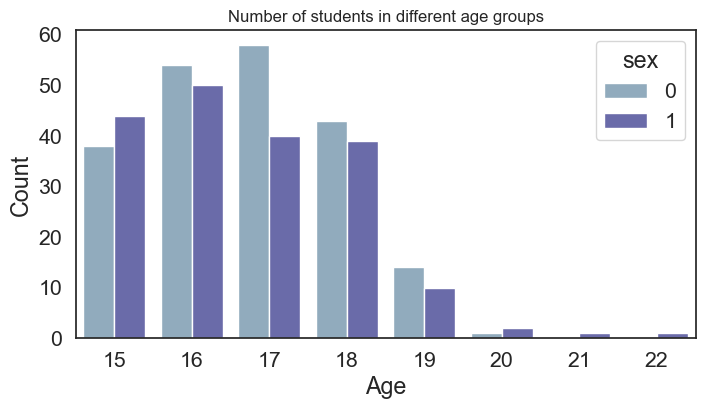

In [1616]:
### Age & Gender Distribution and its effect on grade outcome
### Marking Final Grade as Categorical Value & Viewing their Count
male_studs = len(df[df['sex'] == 1])
female_studs = len(df[df['sex'] == 0])
print('Number of male students:', male_studs)
print('Number of female students:', female_studs)
fig = plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='age', hue='sex').set_title('Number of students in different age groups', fontsize=12)
plt.xlabel("Age")
plt.ylabel("Count")

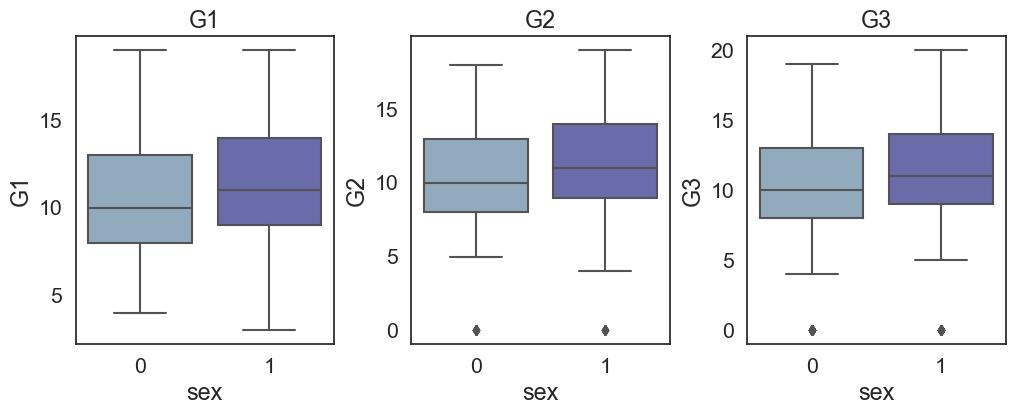

In [1617]:
#Whether there's a gender difference in grade distribution in G1 G2 AND G3
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
ax1 = sns.boxplot(data=df, x='sex', y='G1', ax=axes[0])
ax1.set_title('G1')
ax2 = sns.boxplot(data=df, x='sex', y='G2', ax=axes[1])
ax2.set_title('G2')
ax3 = sns.boxplot(data=df, x='sex', y='G3', ax=axes[2])
ax3.set_title('G3')
plt.show()

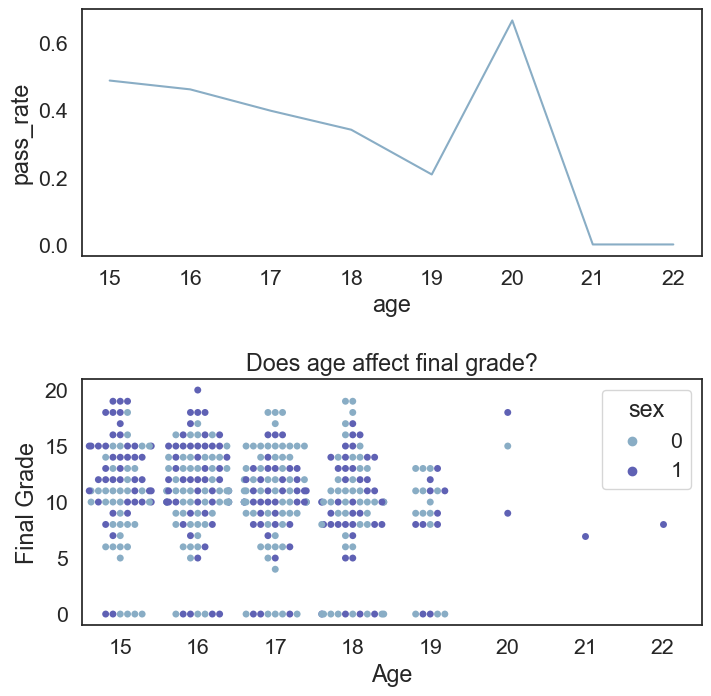

In [1618]:
#Creat the variable finalGrade, which is one when a student passes (>=20) and 0 when a student fails (<20)
df['finalGrade'] = np.where(df['G3'] >= 12, 'Pass', 'Fail')
df['finalGrade'].replace(['Fail', 'Pass'], [0, 1], inplace=True)
# Whether there's a gender difference in grade distribution in G1 G2 AND G3
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
age_data = df.groupby('age')['finalGrade'].agg([('pass_rate', 'mean'), ('nobs', 'count')]).reset_index(drop=False)
age_pass = sns.lineplot(x=age_data.age, y=age_data['pass_rate'], ax=axes[0])
fig.subplots_adjust(hspace=0.5)
b = sns.swarmplot(x='age', y='G3', hue='sex', data=df, ax=axes[1])
b.axes.set_title('Does age affect final grade?')
b.set_xlabel('Age')
b.set_ylabel('Final Grade')
plt.show()

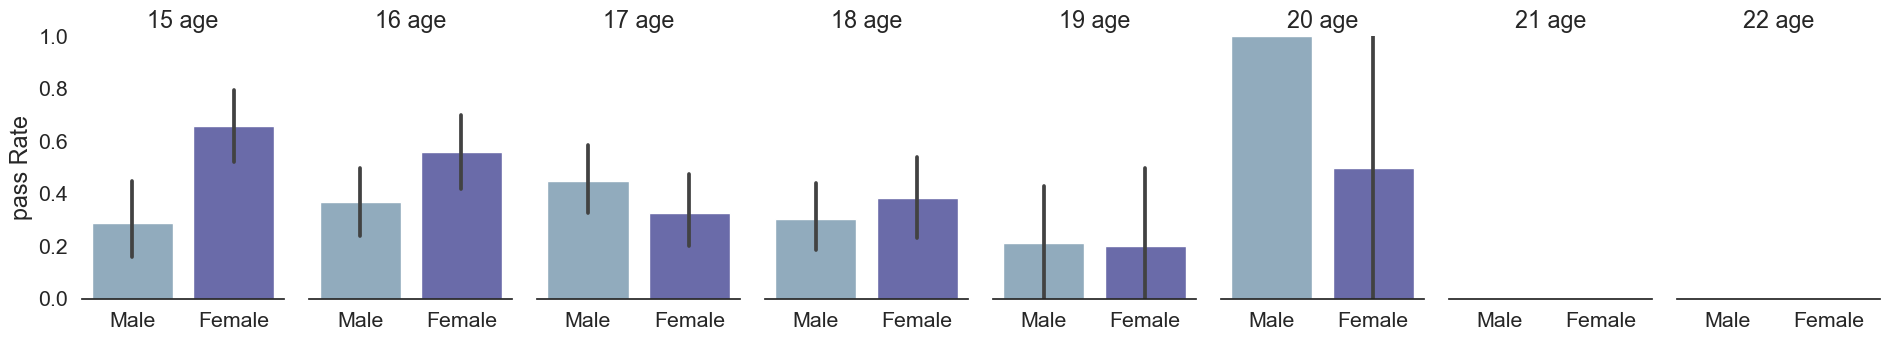

In [1619]:
g = sns.catplot(data=df, x="sex", y="finalGrade", col="age", kind="bar", height=4, aspect=.6, ax=axes[0])
g.set_axis_labels("", "pass Rate")
g.set_xticklabels(["Male", "Female"])
g.set_titles("{col_name} {col_var}")
g.set(ylim=(0, 1))
g.despine(left=True)

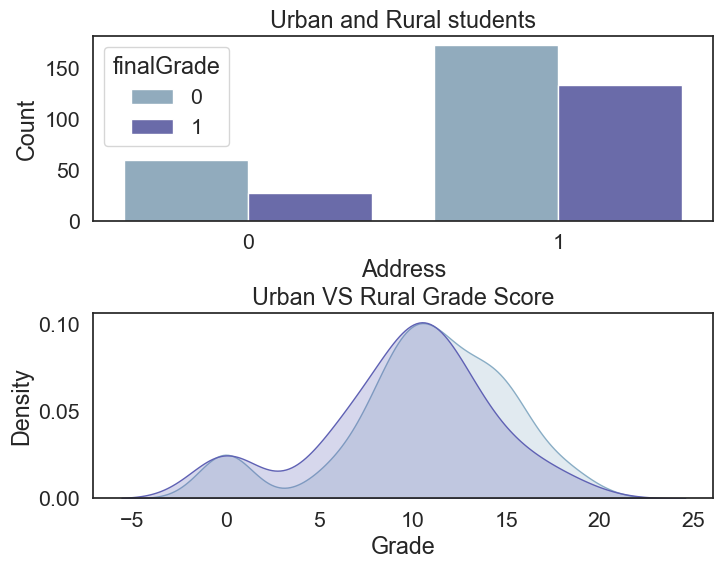

In [1620]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

#Whether geography affects grade outcome 
add_plt = sns.countplot(data=df, x='address', hue="finalGrade", ax=axes[0])
add_plt.axes.set_title('Urban and Rural students')
add_plt.set_xlabel('Address')
add_plt.set_ylabel('Count')

fig.subplots_adjust(hspace=0.5, wspace=0.125)
# Grade distribution by address
sns.kdeplot(df.loc[df['address'] == 1, 'G3'], label='Urban', shade=True, ax=axes[1])
sns.kdeplot(df.loc[df['address'] == 0, 'G3'], label='Rural', shade=True, ax=axes[1])
plt.title('Urban VS Rural Grade Score')
plt.xlabel('Grade')
plt.ylabel('Density')
plt.show()

### EDA for Base Model
*Victoria Shi*

Insights used for base model development
1. Period 1 (`G1`) and Period 2 (`G2`) grades are strongly correlated with each other, as evidenced by the darker shade on the pairwise correlation plot.
2. Period 1 (`G1`) and Period 2 (`G2`) grades are highly indicative of the final grade (`G3`), as evidenced by the scatterplot displaying the relationship `between` G1 and `G2`, with data points colored based on `G3`.
3. Both the bar plot based on the importance scores of the decision tree and the line plot demonstrate that `absences` and `failures` are crucial for predicting the final grades, with grades decreasing as absences and failures increase.
4. `Medu` (mother's education) and `Fedu` (father's education) are strongly correlated, so we combined them into `famEdu` (family education).
5. `Dalc` (weekday alcohol consumption) and `Walc` (weekend alcohol consumption) are strongly correlated, so we combined them into `Alc` (alcohol consumption).
6. A new correlation plot after removing and combining predictors shows that major dependencies among predictors have been resolved.
7. Parents' jobs (`Mjob` and `Fjob`) also affect a student's grades. However, due to the difficulty in generalizing their impact across various categories, we did not focus on this factor during the base model development. Nevertheless, it remains an important aspect to consider in future analyses or more specialized models.

Text(0.5, 1.0, 'Final Grade G3 (Binary) Distribution')

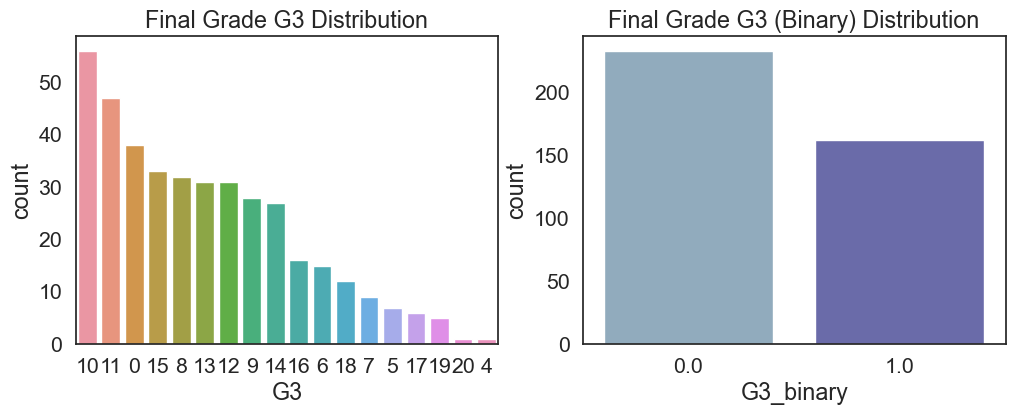

In [1621]:
data = pd.read_csv("data/student-mat.csv")
# Create a new column 'G3_binary' in the data frame
# Assign 0 to all rows where G3 is less than 12
data.loc[data.G3 < 12, 'G3_binary'] = 0

# Assign 1 to all rows where G3 is greater than or equal to 12
data.loc[data.G3 >= 12, 'G3_binary'] = 1
fig = plt.figure(figsize=(12, 4))
# Plot a count plot of the 'G3' column and set the title
fig.add_subplot(1, 2, 1)
sns.countplot(x='G3', data=data, order=data['G3'].value_counts().index).set_title("Final Grade G3 Distribution")

# Plot a count plot of the 'G3_binary' column and set the title
fig.add_subplot(1, 2, 2)
sns.countplot(x=data.G3_binary, order=data.G3_binary.value_counts().index).set_title(
    "Final Grade G3 (Binary) Distribution")

Text(0.5, 1.0, 'Pairwise correlation')

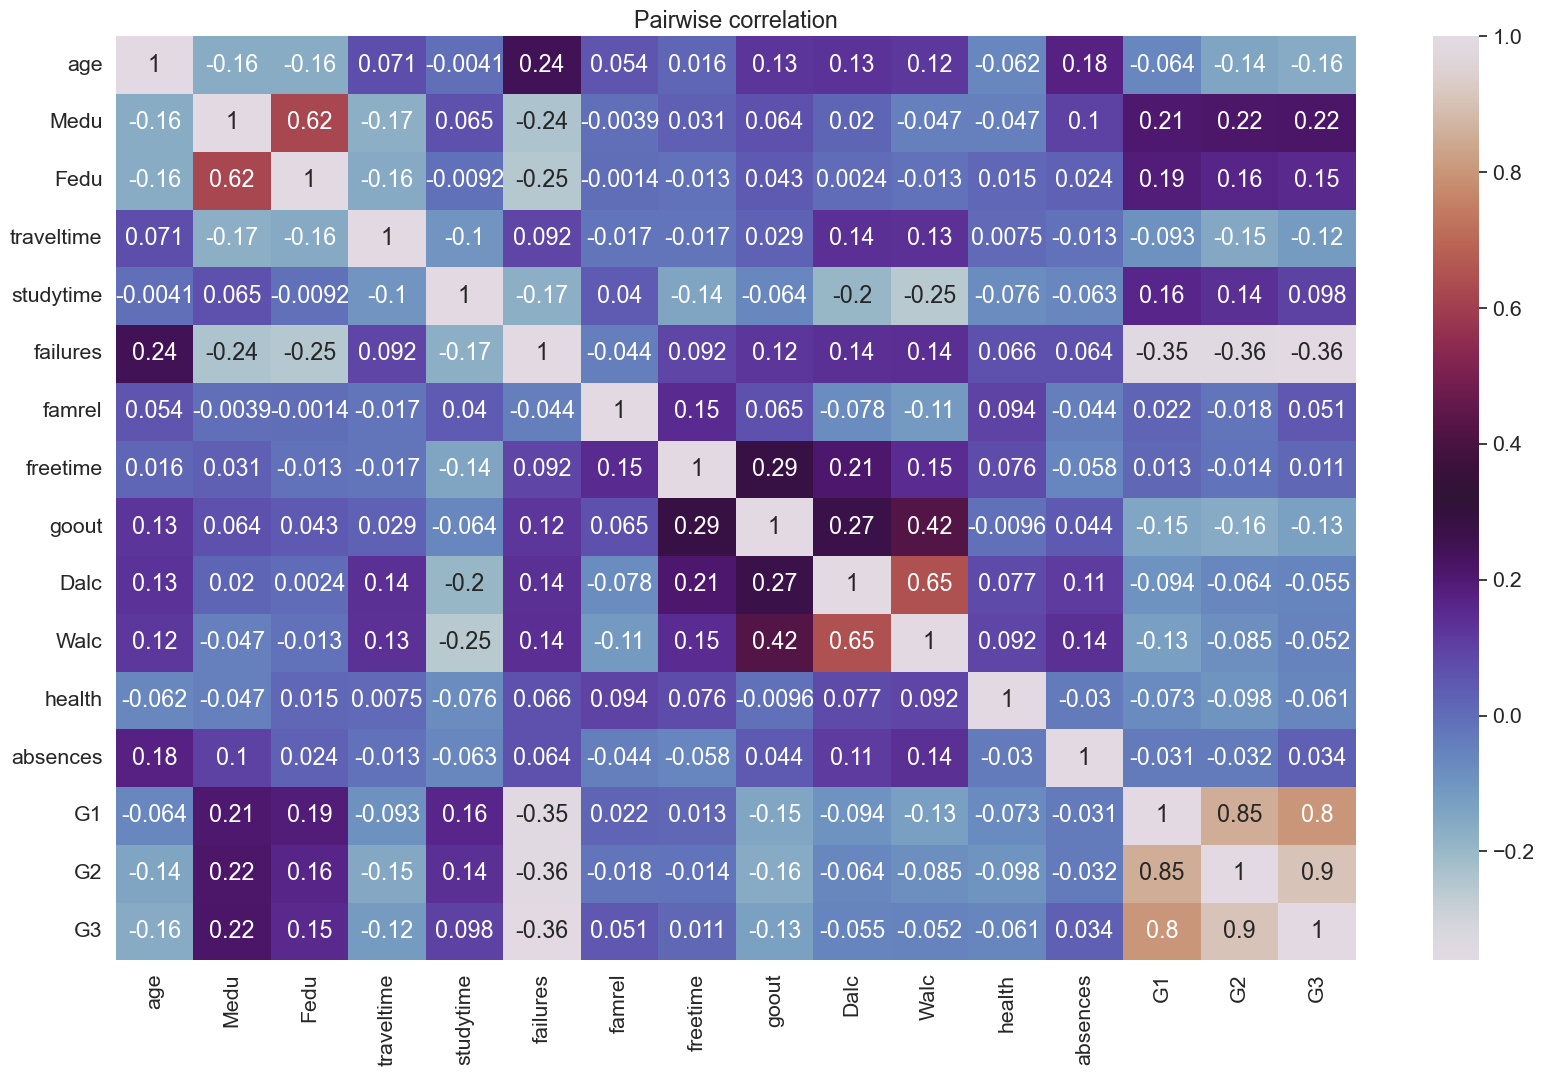

In [1622]:
plt.figure(figsize=(20, 12))
data = data.drop(columns='G3_binary')
# plot the correlation among variables that are ORIGINALLy numerical
sns.heatmap(data.corr(), cmap='twilight', annot=True).set_title("Pairwise correlation")

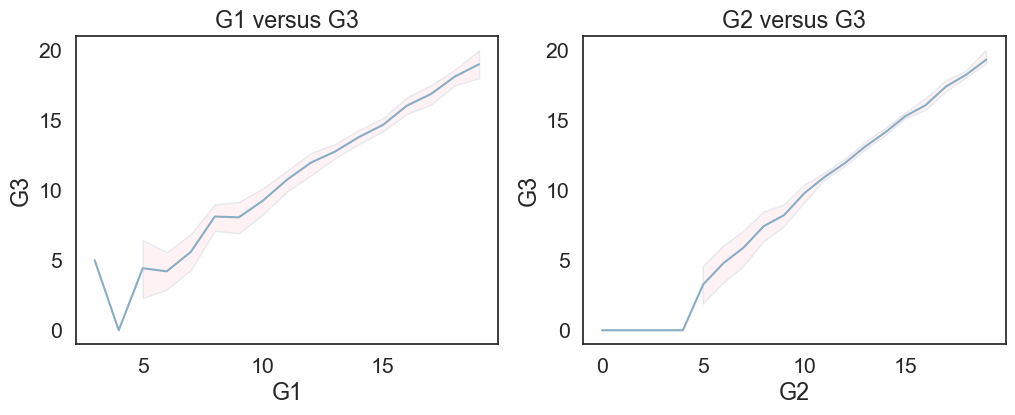

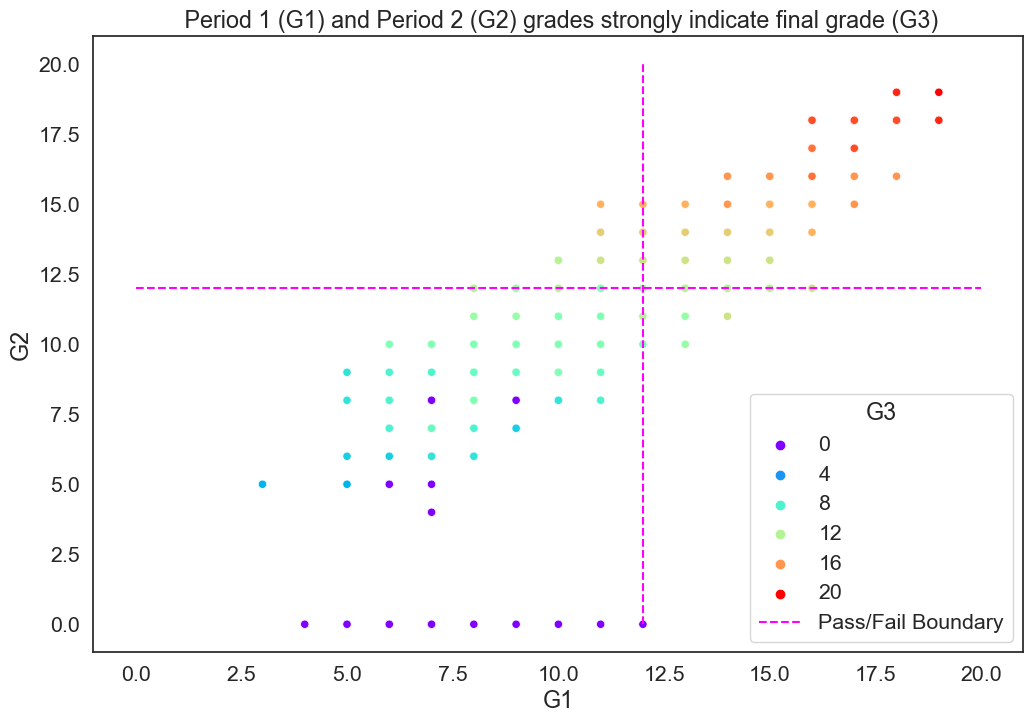

In [1623]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
sns.lineplot(x='G1', y='G3', err_kws={'fc': 'pink'}, data=data).set_title('G1 versus G3')
fig.add_subplot(1, 2, 2)
sns.lineplot(x='G2', y='G3', err_kws={'fc': 'pink'}, data=data).set_title('G2 versus G3')
plt.show()

fig = plt.figure(figsize=(12, 8))
sns.scatterplot(x='G1', y='G2', hue='G3', palette='rainbow', data=data).set_title(
    ' Period 1 (G1) and Period 2 (G2) grades strongly indicate final grade (G3)')
plt.hlines(12, 0, 20, color="magenta", linestyle="--")
plt.vlines(12, 0, 20, color="magenta", linestyle="--", label="Pass/Fail Boundary")
plt.legend(loc="lower right", title="G3")
plt.show()

In [1624]:
# Since G1, G2, and G3 are highly correlated, we remove G2 and G3
data = data.drop(columns=["G1", "G2"])

Text(0.5, 1.0, 'Pairwise correlation')

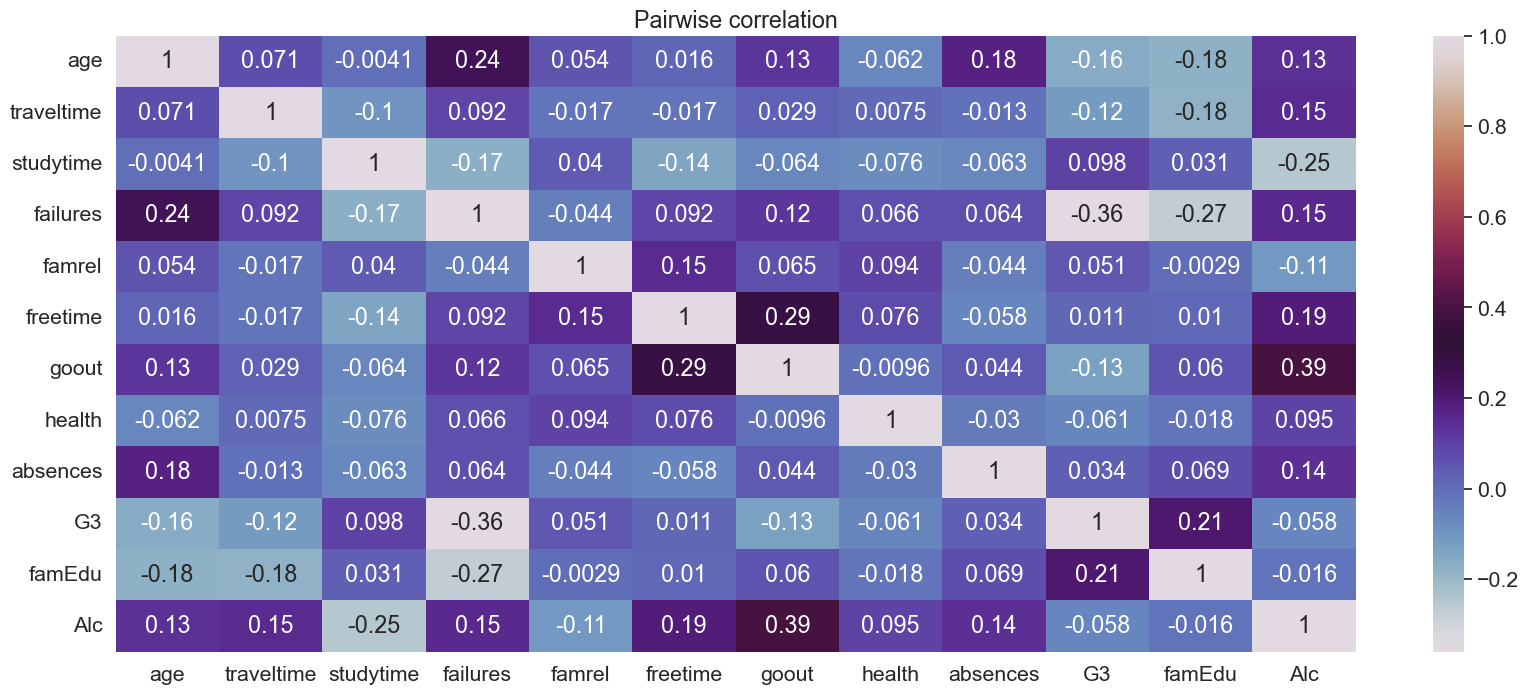

In [1625]:
# combine father education and mother education into alcohol
data['famEdu'] = data['Fedu'] + data['Medu']
# combine day alc and week into alcohol
data['Alc'] = data['Walc'] + data['Dalc']
# drop redundant columns
data = data.drop(columns=["Fedu", 'Medu', 'Walc', 'Dalc'])

plt.figure(figsize=(20, 8))
sns.heatmap(data.corr(), cmap='twilight', annot=True).set_title("Pairwise correlation")

Text(0.5, 1.0, 'Father job vs G3')

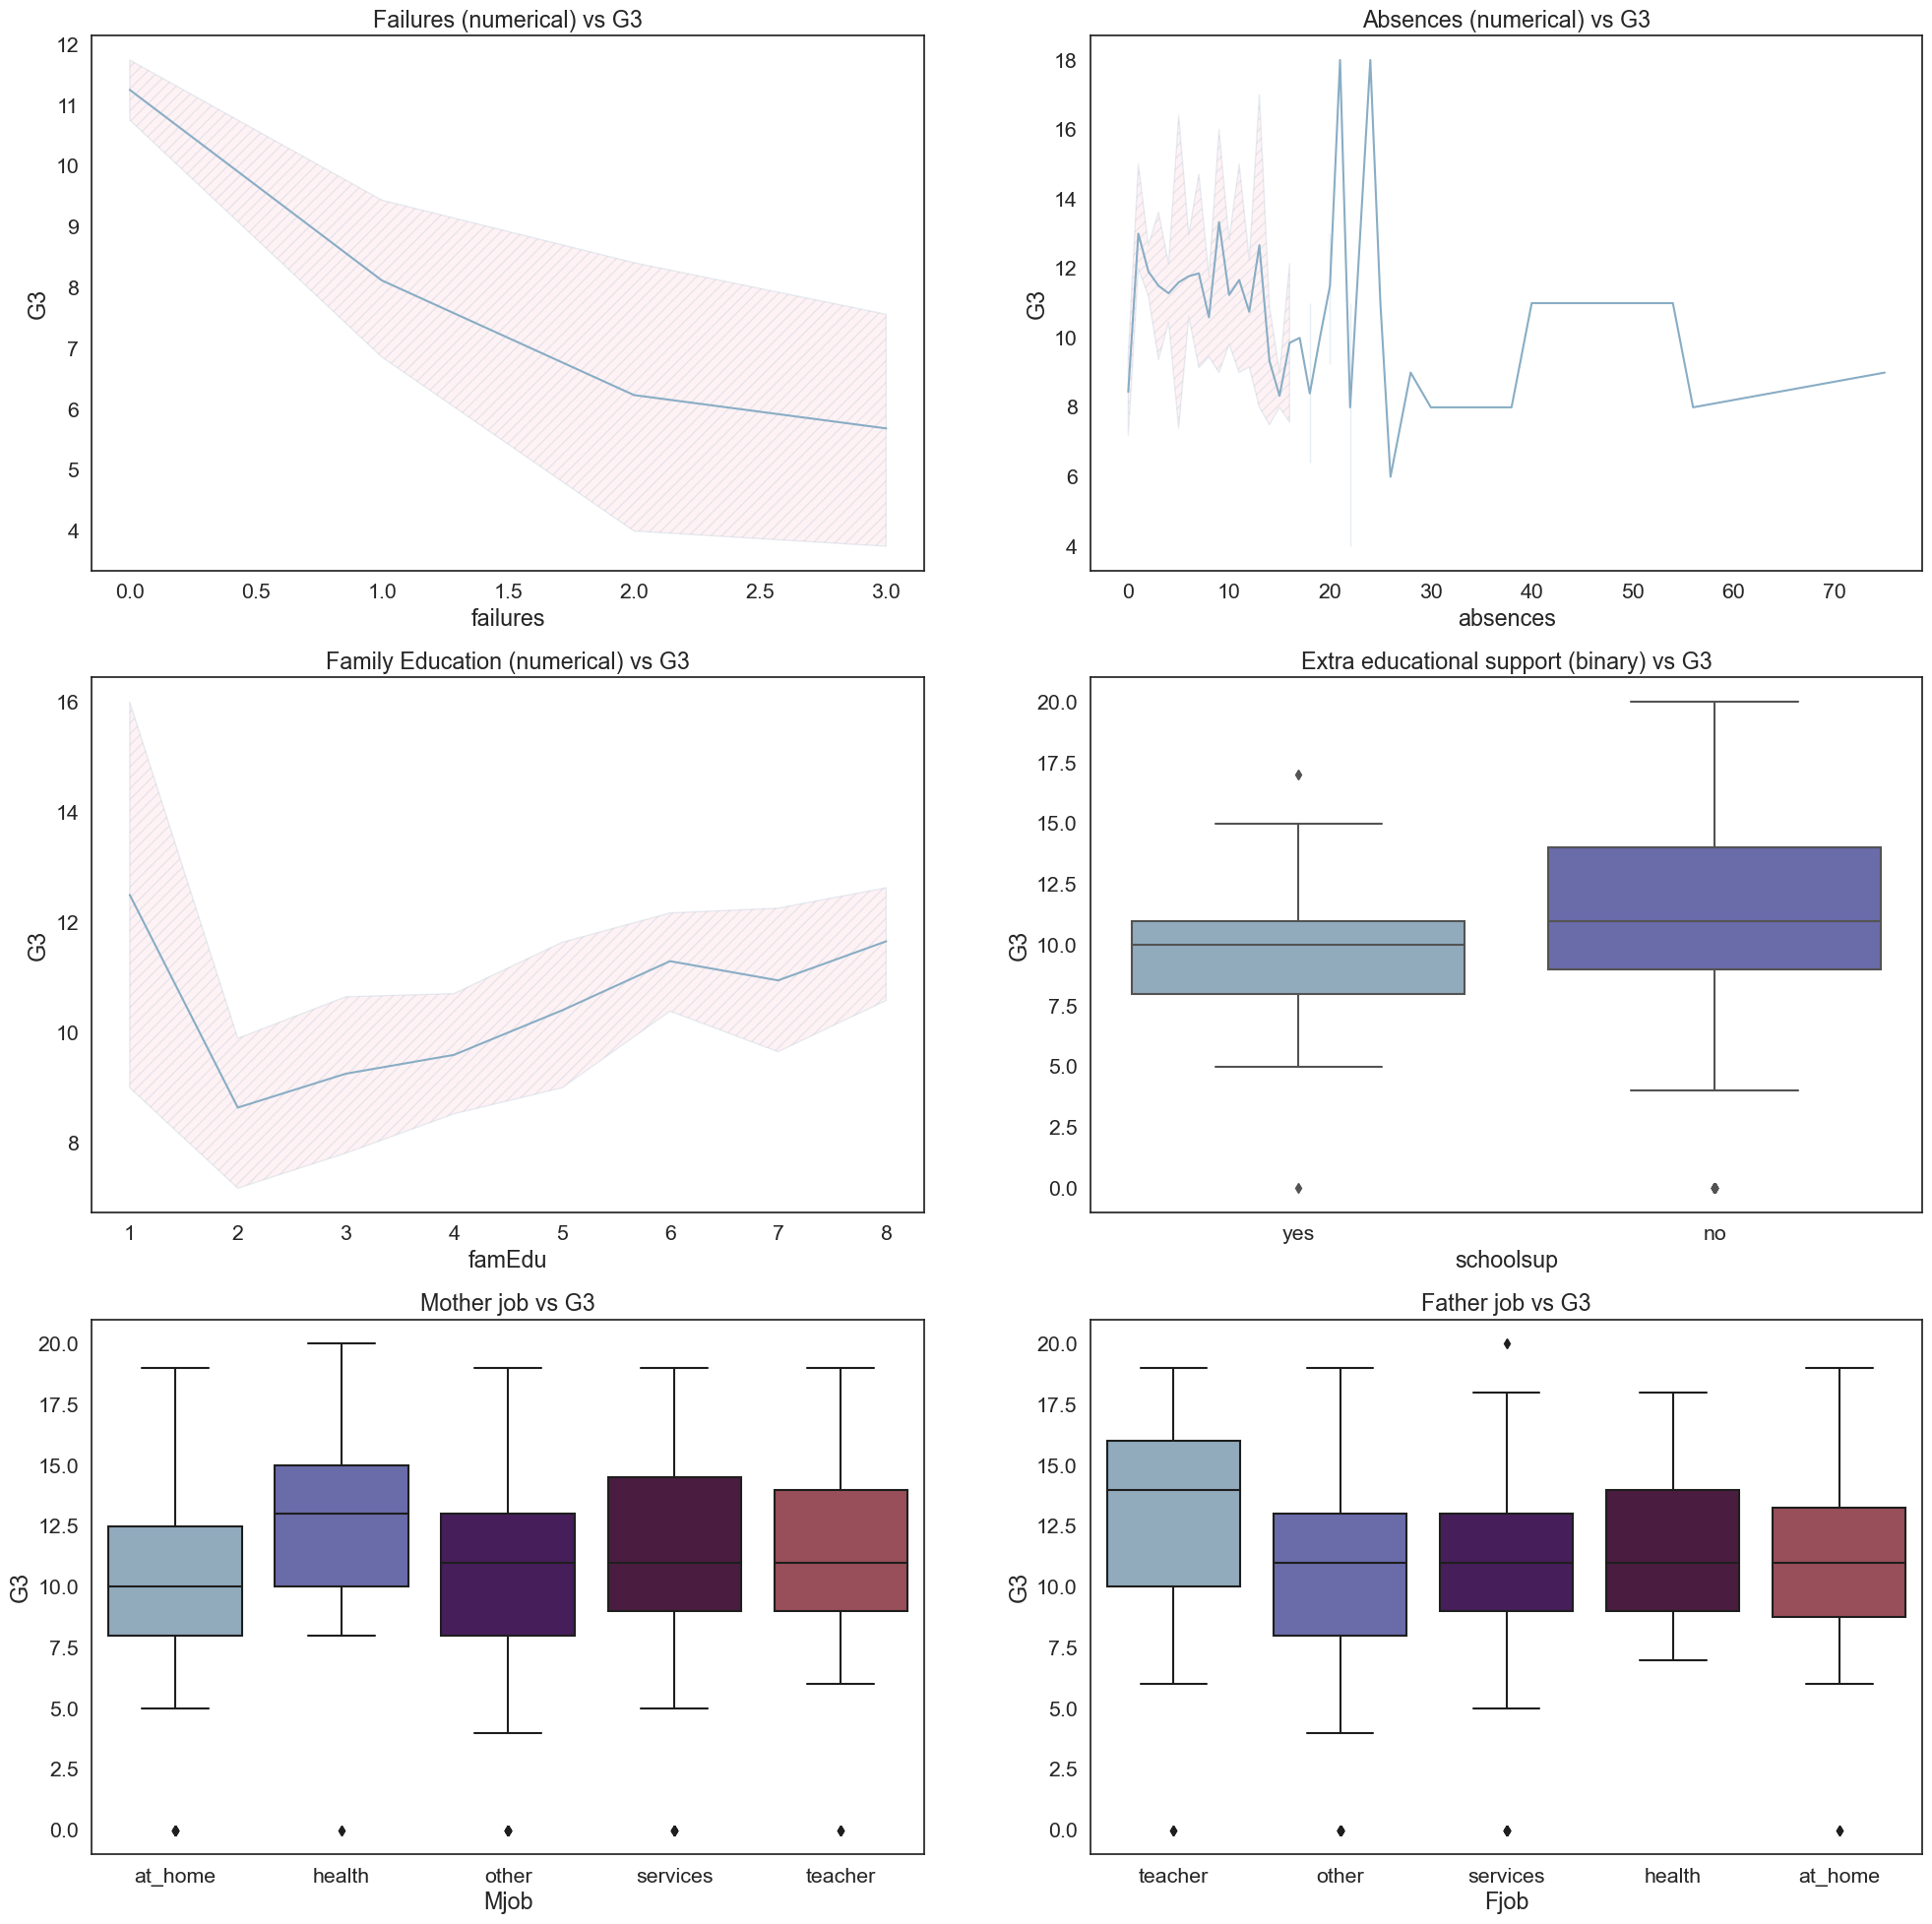

In [1626]:
fig = plt.figure(figsize=(24, 24))
fig.add_subplot(3, 2, 1)
sns.lineplot(x='failures', y='G3', err_kws={'hatch': '///', 'fc': 'pink'}, data=data).set_title(
    'Failures (numerical) vs G3')
fig.add_subplot(3, 2, 2)
sns.lineplot(x='absences', y='G3', err_kws={'hatch': '///', 'fc': 'pink'}, data=data).set_title(
    'Absences (numerical) vs G3')
fig.add_subplot(3, 2, 3)
sns.lineplot(x='famEdu', y='G3', err_kws={'hatch': '///', 'fc': 'pink'}, data=data).set_title(
    'Family Education (numerical) vs G3')
fig.add_subplot(3, 2, 4)
data = pd.read_csv("data/student-mat.csv")
sns.boxplot(x='schoolsup', y='G3', data=data).set_title('Extra educational support (binary) vs G3')
fig.add_subplot(3, 2, 5)
sns.boxplot(x='Mjob', y='G3', data=data).set_title('Mother job vs G3')
fig.add_subplot(3, 2, 6)
sns.boxplot(x='Fjob', y='G3', data=data).set_title('Father job vs G3')

### EDA for Progress Model
*Yiru Zhang*

In [1627]:
#In order to measure if a student improves from the previous test
#create categorical variables G1_G2 and G2_G3, which will be 1 if a students improves (G2/G3 score higher than G1/G2)
#and 0 otherwise (no improvement or decrease in grade)
df['G1_G2'] = 0
df.loc[df.G2 > df.G1, 'G1_G2'] = 1
df['G2_G3'] = 0
df.loc[df.G3 > df.G2, 'G2_G3'] = 1

Text(0.5, 1.0, "Father's job as civil 'services' (e.g. administrative or police) vs G1 G2 Progress")

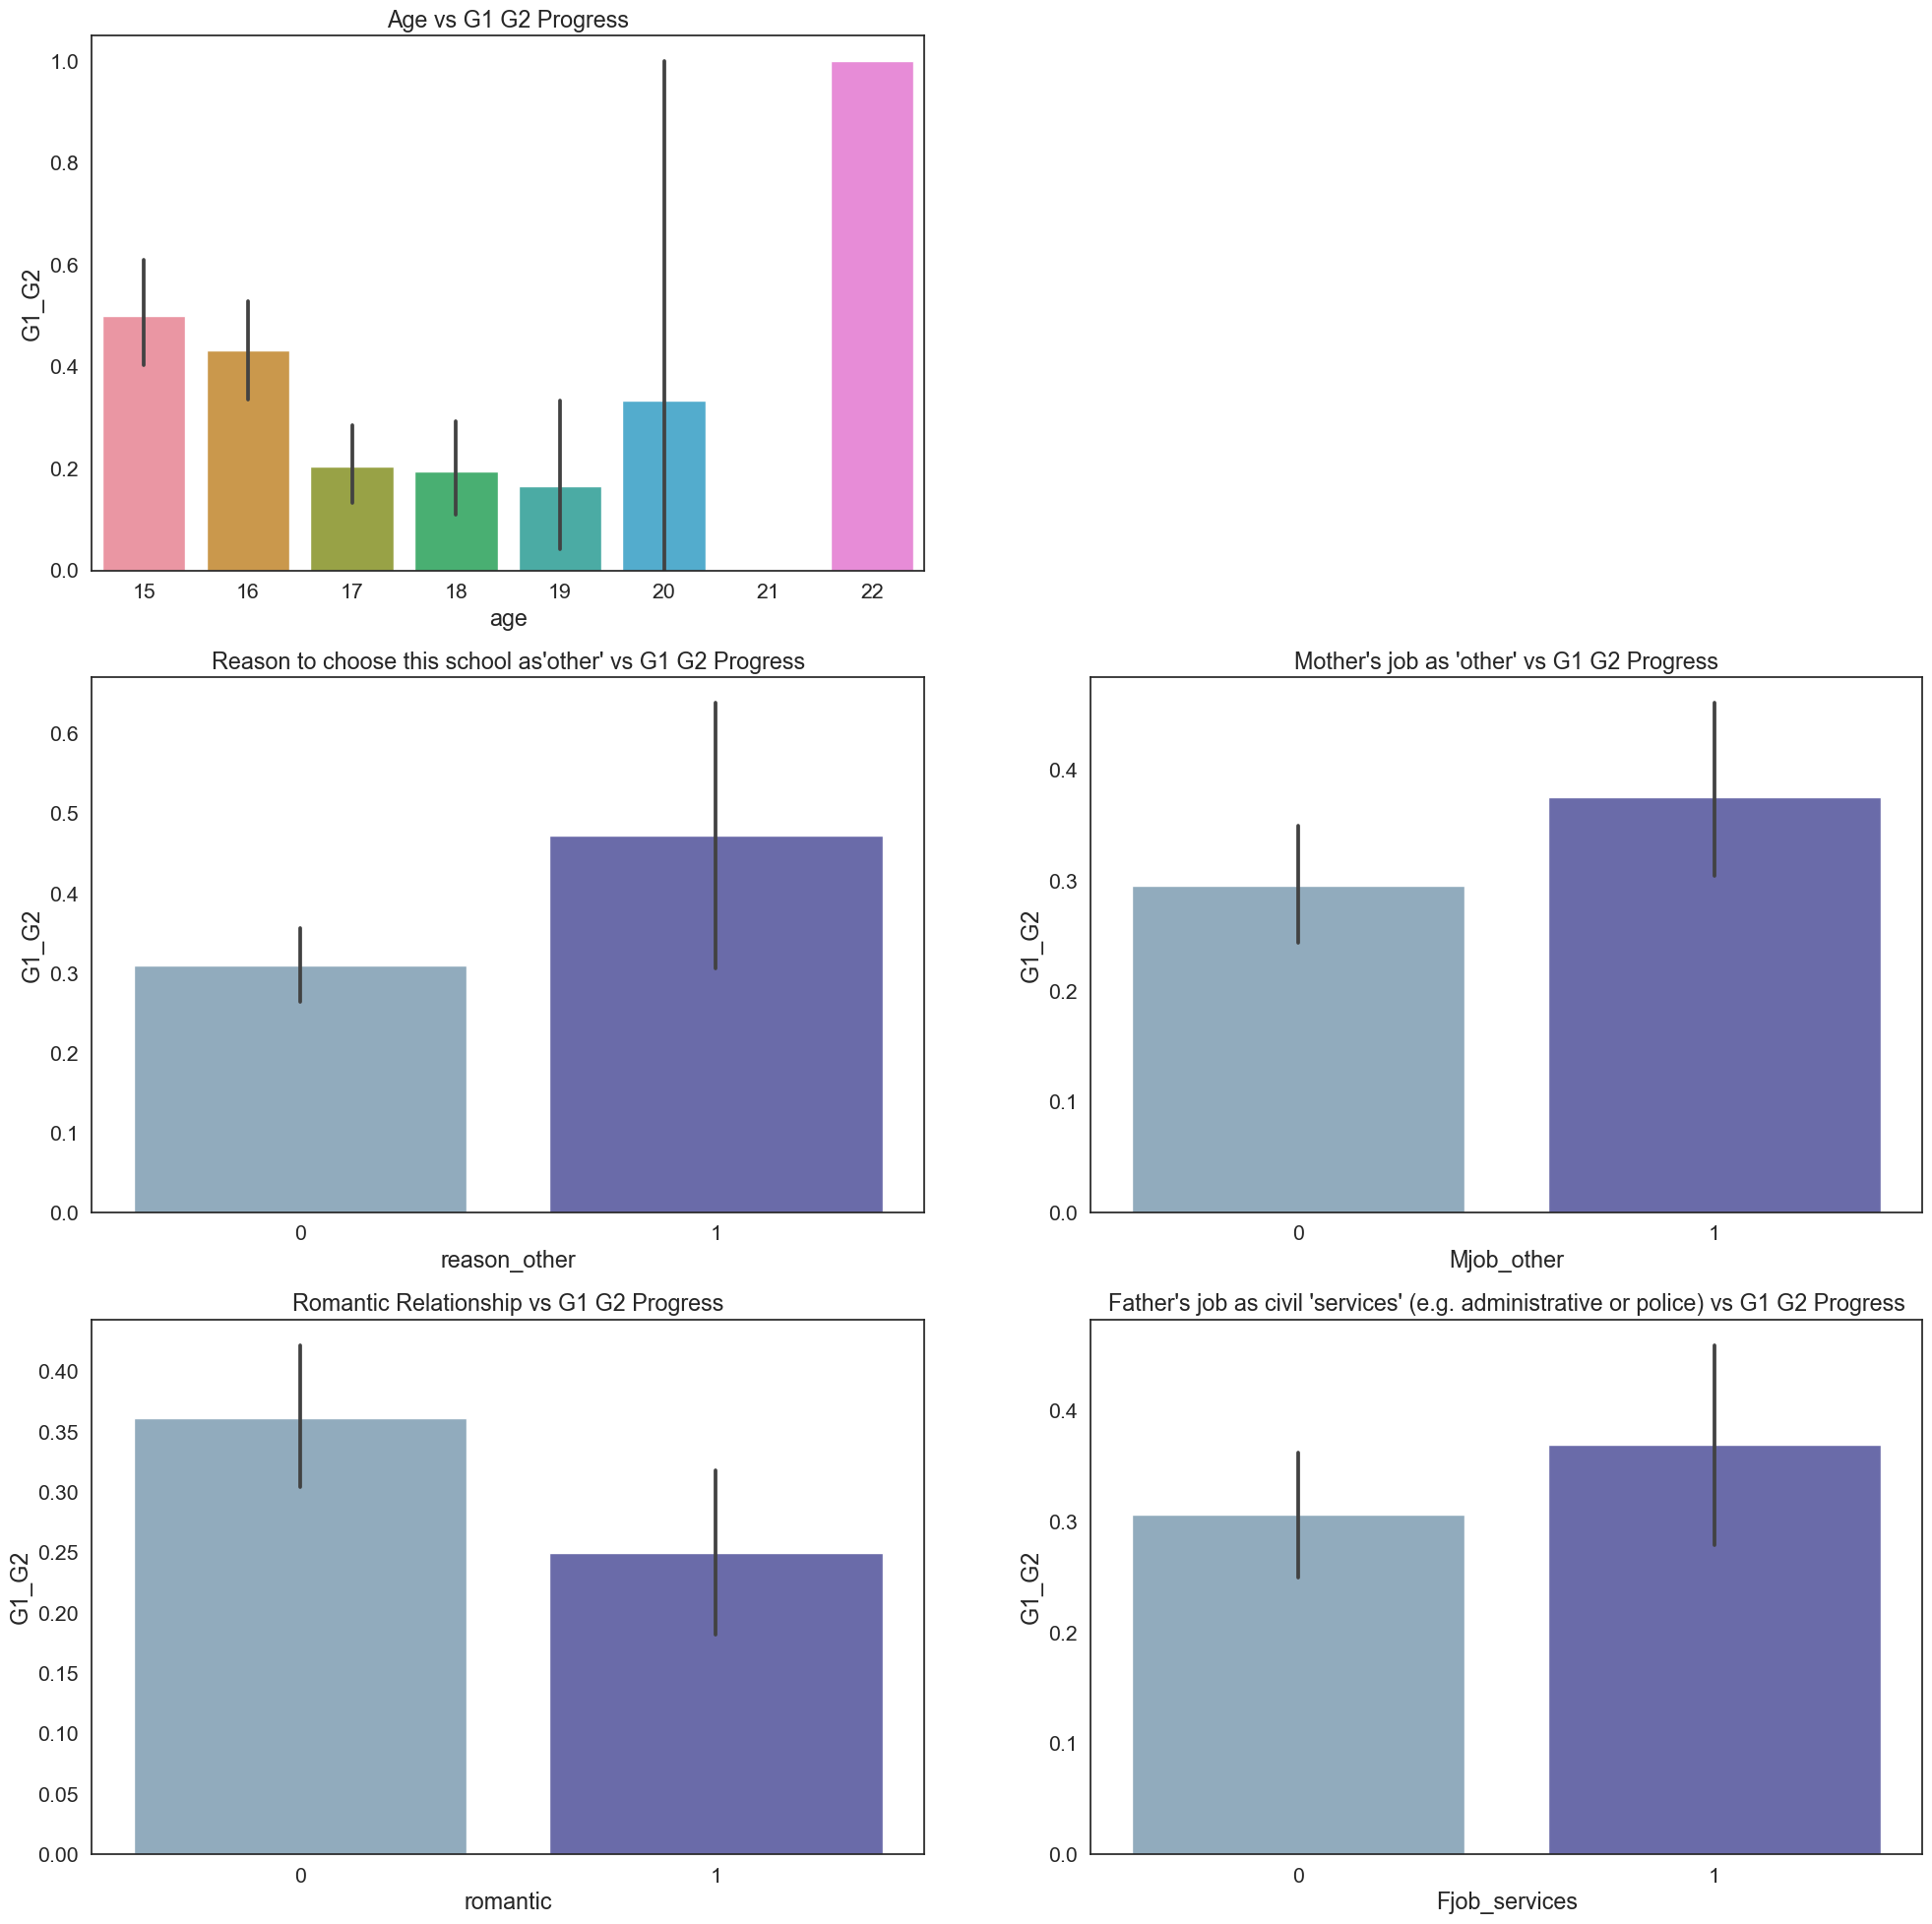

In [1628]:
#After observing the barplots of all the predictors vs G1 to G2 progress, here are the five graphs that show
#a relatively large change in the response variable G1_G2 as the predictor changes value

fig = plt.figure(figsize=(24, 24))
fig.add_subplot(3, 2, 1)
sns.barplot(x='age', y='G1_G2', data=df).set_title('Age vs G1 G2 Progress')
#Note: for age 21 and 22, there is only one observation with those ages, so we should not overgeneralize our eda to them
#It is over generalization to say that student aged 22 will definitely improve their grades(same thing for age 21)
fig.add_subplot(3, 2, 3)
sns.barplot(x='reason_other', y='G1_G2', data=df).set_title("Reason to choose this school as'other' vs G1 G2 Progress")
fig.add_subplot(3, 2, 4)
sns.barplot(x='Mjob_other', y='G1_G2', data=df).set_title("Mother's job as 'other' vs G1 G2 Progress")
fig.add_subplot(3, 2, 5)
sns.barplot(x='romantic', y='G1_G2', data=df).set_title('Romantic Relationship vs G1 G2 Progress')
fig.add_subplot(3, 2, 6)
sns.barplot(x='Fjob_services', y='G1_G2', data=df).set_title(
    "Father's job as civil 'services' (e.g. administrative or police) vs G1 G2 Progress")

Text(0.5, 1.0, "Reason to choose this school as'course' vs G1 G2 Progress")

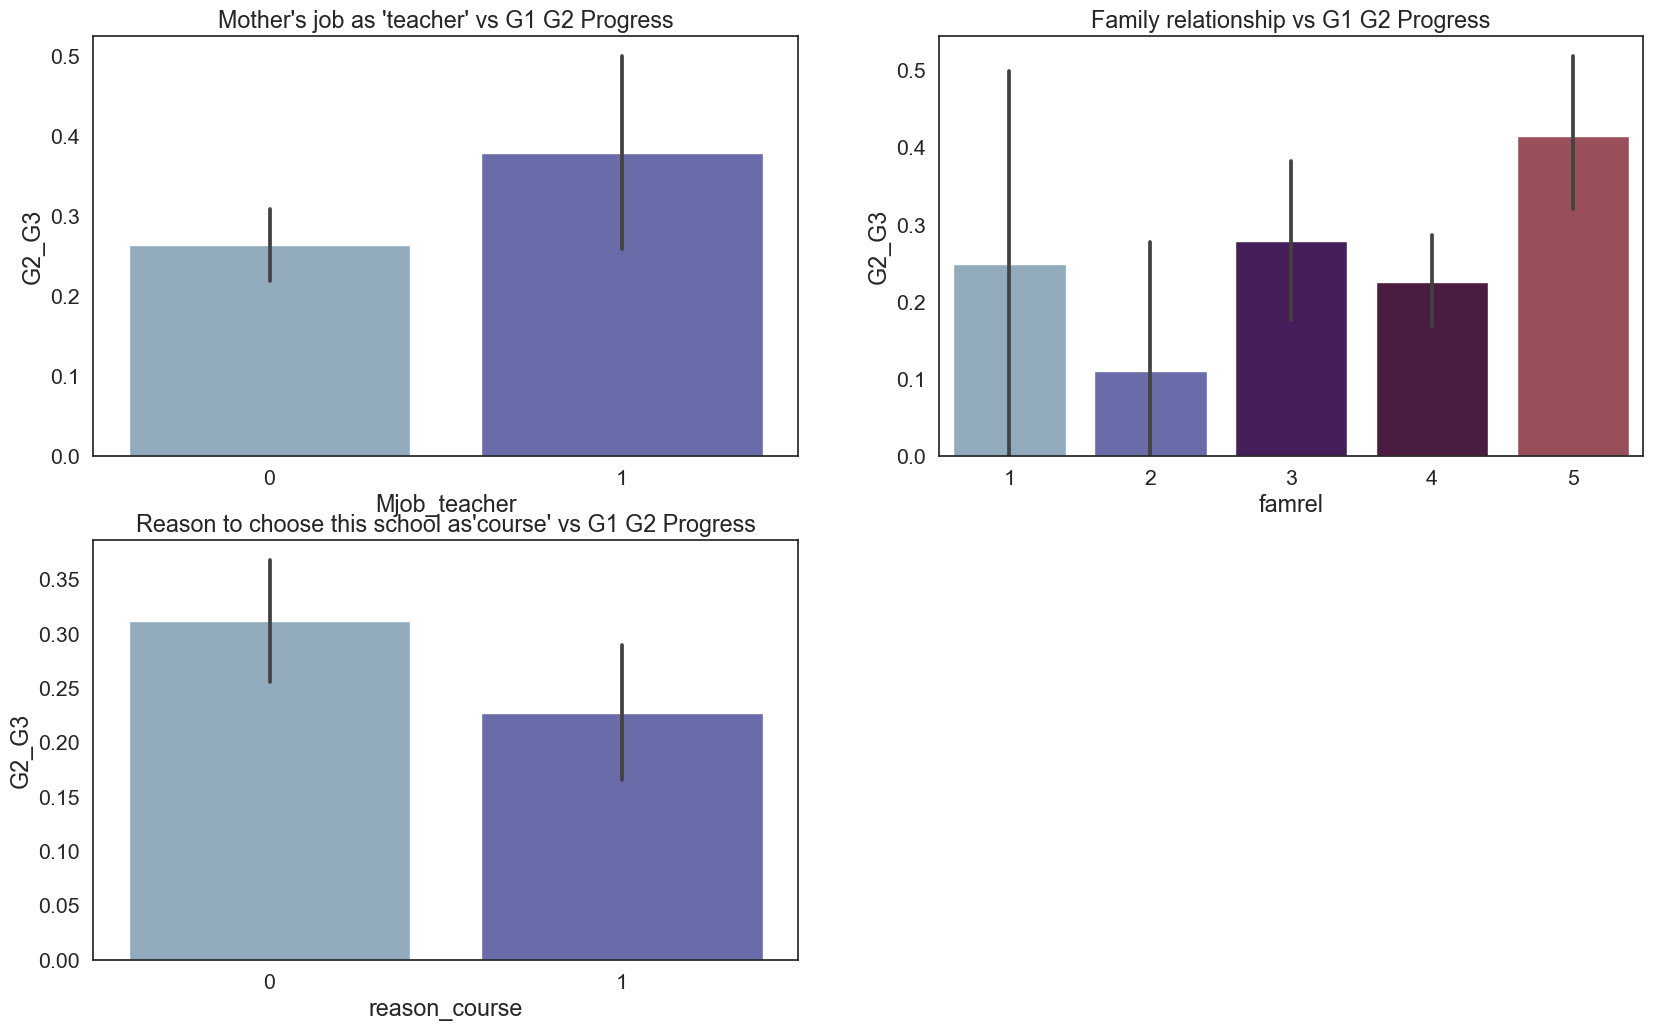

In [1629]:
#Mjob_teacher+famrel+reason_course
#After observing the barplots of all the predictors vs G2 to G3 progress, here are the three graphs that show
#a relatively large change in the response variable G2_G3 as the predictor changes value

fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
sns.barplot(x='Mjob_teacher', y='G2_G3', data=df).set_title("Mother's job as 'teacher' vs G1 G2 Progress")
fig.add_subplot(2, 2, 2)
sns.barplot(x='famrel', y='G2_G3', data=df).set_title("Family relationship vs G1 G2 Progress")
fig.add_subplot(2, 2, 3)
sns.barplot(x='reason_course', y='G2_G3', data=df).set_title(
    "Reason to choose this school as'course' vs G1 G2 Progress")

## Developing the model

### Logistic Regression Model
*Yuyan*

In [1630]:
#Have the predictors and response variable ready for Lasso
predictors = list(df.columns)[0:43]
remove = ['G1', 'G2', 'G3']
pred_filter = [x for x in predictors if x not in remove]

X = df[pred_filter]
y = df.finalGrade

# Split the data into training and test sets using the train_test_split function
# The test set will be 20% of the total data and the random state is set to 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Combining back X and y back to one df
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [1631]:
#Lasso for variable selection

#Scaling X (training data)
scaler = StandardScaler()
scaler.fit(X_train)
Xstd = scaler.transform(X_train)

#Creating a range of values of the tuning parameter
alphas = 10 ** np.linspace(10, -2, 100) * 0.1

lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y_train)
    coefs.append(lasso.coef_)

#use cross validation to find the optimal value of the tuning parameter - lambda
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=100000)
lassocv.fit(Xstd, y_train)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.016297508346206403

In [1632]:
#select the five predictors that have the highest coefficients
coeff = pd.concat([pd.Series(X_train.columns), np.abs(pd.Series(lassocv.coef_))], axis=1)
coeff.columns = ['predictor', 'coefficient']
coeff.sort_values(by='coefficient', ascending=False, inplace=True)
predictor_subset = coeff['predictor'][0:5]

In [1633]:
predictor_subset

9         failures
10       schoolsup
27    Mjob_teacher
6             Medu
1              sex
Name: predictor, dtype: object

In [1634]:
#building a logistic regression model with selected variables
logit_model = smf.logit(formula='finalGrade~' + '+'.join(predictor_subset), data=train).fit(disp=False)
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             finalGrade   No. Observations:                  316
Model:                          Logit   Df Residuals:                      310
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.1553
Time:                        12:29:06   Log-Likelihood:                -182.65
converged:                       True   LL-Null:                       -216.24
Covariance Type:            nonrobust   LLR p-value:                 3.990e-13
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.2479      0.400     -3.122      0.002      -2.031      -0.465
failures        -1.3128      0.306     -4.285      0.000      -1.913      -0.712
schoolsup       -1.6826      0.493     -3.413      0.001      -2.649      -0.716
Mjob_teacher    -1.3522      0.402     -3.362      0.001      -2.140      -0.564
Medu             0.4451      0.135      3.302      0.001       0.181       0.709
sex              0.8009      0.262      3.059      0.002       0.288       1.314
================================================================================
"""

In [1635]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(_data, actual_values, model, cutoff=0.5):
    #Predict the values using the Logit model
    pred_values = model.predict(_data)
    # Specify the bins
    bins = np.array([0, cutoff, 1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0', 1: 'Actual 1'})
    # Calculate the accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    fnr = (cm[1, 0]) / (cm[1, 0] + cm[1, 1])
    precision = (cm[1, 1]) / (cm[0, 1] + cm[1, 1])
    fpr = (cm[0, 1]) / (cm[0, 0] + cm[0, 1])
    tpr = (cm[1, 1]) / (cm[1, 0] + cm[1, 1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [1636]:
# Metric for prediction. Threshold of 0.6 was chosen to reduce FPR, while maintaining accuracy. 
# However, both metrics are not idea (FPR too high, accuracy too low)
confusion_matrix_data(train, train.finalGrade, logit_model, cutoff=0.6)

Classification accuracy = 70.3%
Precision = 72.2%
TPR or Recall = 51.1%
FNR = 48.9%
FPR = 15.1%
ROC-AUC = 75.7%


In [1637]:
# Metrics on test data
confusion_matrix_data(test, test.finalGrade, logit_model, cutoff=0.6)

Classification accuracy = 65.8%
Precision = 43.8%
TPR or Recall = 28.0%
FNR = 72.0%
FPR = 16.7%
ROC-AUC = 58.6%


### Base Model Development
*Victoria*

In [1638]:
######-----------Shuffling the dataset via train-test split for K-fold------------#########

# create a copy of the cleaned and transformed data frame and assign it to data (for base model development)
data = df_model_dev.copy()
predictor_cols = [col for col in data.columns.tolist() if col not in ['G1', 'G2', 'G3']]

X = data[predictor_cols]

y = data.G3

# Define the KFold cross-validation object with 10 splits, a random state of 1, and shuffling enabled
k_fold = KFold(n_splits=10, random_state=1, shuffle=True)

# Split the data into training and test sets using the train_test_split function
# The test set will be 20% of the total data and the random state is set to 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"dimension of training set: {X_train.shape}\ndimension of testing set: {X_test.shape}")

dimension of training set: (316, 41)
dimension of testing set: (79, 41)


#### Important Predictors (Overall)

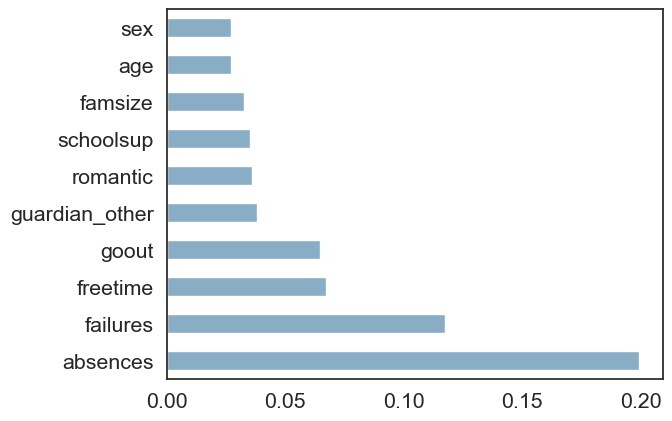

In [1639]:
# Initialize a DecisionTreeRegressor object and set the random state to 1 for reproducibility
model_tree = DecisionTreeRegressor(random_state=1)

# Fit the model to the training data
model_tree.fit(X_train, y_train)

# Create a pandas Series object to store the feature importance
importance = pd.Series(model_tree.feature_importances_, index=X.columns)

# Plot the 10 largest feature importance using a horizontal bar plot
importance.nlargest(10).plot(kind='barh')
plt.show()

#### Important Categorical Predictors

In [1640]:
X_cat = X.drop(columns='Alc')

# Select only categorical columns from the dataframe X_cat
X_cat = X_cat.loc[:, [col for col in X_cat.columns if col not in num_col]]

# Apply SelectKBest with chi-square test to select the best 5 features
k_best = SelectKBest(score_func=chi2, k=5).fit(X_cat, y)

# Create a pandas series to store the scores of each feature
df_score = pd.Series(data=k_best.scores_, index=X_cat.columns)

# Sort the scores in descending order
df_score.sort_values(ascending=False)[:5]

schoolsup        28.319018
Fjob_teacher     23.133348
Mjob_at_home     22.615347
Mjob_health      22.416110
Mjob_services    21.588835
dtype: float64

In [1641]:
# concatenate X_train and y_train so that predictors and response are in the same dataset
train = pd.concat([X_train, y_train], axis=1)

# concatenate X_test and y_test so that predictors and response are in the same dataset
test = pd.concat([X_test, y_test], axis=1)

In [1642]:
# function to test prediction accuracy
def acc(_lm, _Xtest, _ytest):
    y_pred = _lm.predict(_Xtest)
    df = pd.concat([y_pred, _ytest], axis=1)
    test_res = pd.DataFrame(df, columns=["predicted", "actual"], dtype="float64")
    test_res[y_pred < 12], test_res[y_pred >= 12] = 0, 1
    test_res[y_pred < 6], test_res[y_pred >= 12] = 0, 1
    y_test[y_test < 12], y_test[y_test >= 12] = 0, 1
    return np.mean(test_res.predicted == test_res.actual)


# function to format and print result
def display_res(lm_formula):
    lm = smf.ols(formula=lm_formula, data=train).fit()
    p_vals = lm.pvalues
    acc_test = acc(lm, test, y_test)
    acc_full = acc(lm, X, y)
    print(
        f"------ {lm_formula} ------\nP-values \n{p_vals[1:]}\nAccuracy on test set: {acc_test}\tfull dataset: {acc_full}\n")

In [1643]:
# 1 predictor
lm1 = 'G3 ~ absences'
display_res(lm1)
lm2 = 'G3 ~ failures'
display_res(lm2)

------ G3 ~ absences ------
P-values 
absences    0.472992
dtype: float64
Accuracy on test set: 1.0	full dataset: 1.0

------ G3 ~ failures ------
P-values 
failures    2.166413e-10
dtype: float64
Accuracy on test set: 1.0	full dataset: 1.0



In [1644]:
# 2 individual predictors
lm3 = 'G3 ~ absences + failures'
display_res(lm2)
lm4 = 'G3 ~ absences * failures'
display_res(lm4)
print("The small of P-value of `absences:failures` shows its statistical significance!")

------ G3 ~ failures ------
P-values 
failures    2.166413e-10
dtype: float64
Accuracy on test set: 1.0	full dataset: 1.0

------ G3 ~ absences * failures ------
P-values 
absences             6.218229e-01
failures             2.799203e-12
absences:failures    1.473151e-03
dtype: float64
Accuracy on test set: 1.0	full dataset: 1.0

The small of P-value of `absences:failures` shows its statistical significance!


In [1645]:
base_model_final = smf.ols(formula='G3 ~ absences * failures', data=df).fit()
base_model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     24.15
Date:                Wed, 15 Mar 2023   Prob (F-statistic):           2.35e-14
Time:                        12:29:06   Log-Likelihood:                -1127.6
No. Observations:                 395   AIC:                             2263.
Df Residuals:                     391   BIC:                             2279.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.1824      0.282     39.640      0.000      10.628      11.737
absences             -0.0144      0.030     -0.475      0.635      -0.074       0.045
failures             -2.9952      0.367     -8.150      0.000      -3.718      -2.273
absences:failures     0.1382      0.042      3.273      0.001       0.055       0.221
==============================================================================
Omnibus:                       31.773   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.614
Skew:                          -0.689   Prob(JB):                     6.80e-09
Kurtosis:                       3.623   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Progress Model Development
*Yiru Zhang*

In [1646]:
#Have the predictors and response variable ready for Lasso
predictors = list(df.columns)[0:43]
remove = ['G1', 'G2', 'G3']
pred_filter = [x for x in predictors if x not in remove]
X = df[pred_filter]
y1 = df.G1_G2
y2 = df.G2_G3

In [1647]:
#Lasso for G1_G2
#Scaling X
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

#Creating a range of values of the tuning parameter
alphas = 10 ** np.linspace(10, -2, 100) * 0.1

lasso1 = Lasso(max_iter=10000)
coefs1 = []

for a in alphas:
    lasso1.set_params(alpha=a)
    lasso1.fit(Xstd, y1)
    coefs1.append(lasso1.coef_)

#use cross validation to find the optimal value of the tuning parameter - lambda
lassocv1 = LassoCV(alphas=alphas, cv=10, max_iter=100000)
lassocv1.fit(Xstd, y1)

#Optimal value of the tuning parameter - lamda
lassocv1.alpha_

0.04977023564332114

In [1648]:
#select the five predictors that have the highest coefficients
coeff1 = pd.concat([pd.Series(X.columns), np.abs(pd.Series(lasso1.coef_))], axis=1)
coeff1.columns = ['predictor', 'coefficient']
coeff1.sort_values(by='coefficient', ascending=False).head()

,predictor,coefficient
2,age,0.083755
25,Mjob_other,0.061088
35,reason_other,0.060181
17,romantic,0.042777
22,absences,0.039447


In [1649]:
#model built for G1_G2, using the variables from Lasso
progress_model_1_1 = smf.logit(formula='G1_G2~age+reason_other+Mjob_other+romantic+famrel', data=df).fit(disp=False)
progress_model_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  G1_G2   No. Observations:                  395
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.07503
Time:                        12:29:07   Log-Likelihood:                -230.14
converged:                       True   LL-Null:                       -248.80
Covariance Type:            nonrobust   LLR p-value:                 5.129e-07
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.9484      1.672      4.157      0.000       3.672      10.225
age             -0.4348      0.098     -4.435      0.000      -0.627      -0.243
reason_other     0.9210      0.381      2.415      0.016       0.174       1.668
Mjob_other       0.5279      0.235      2.243      0.025       0.067       0.989
romantic        -0.4735      0.253     -1.871      0.061      -0.969       0.022
famrel          -0.1581      0.124     -1.274      0.203      -0.401       0.085
================================================================================
"""

In [1650]:
confusion_matrix_data(df, df.G1_G2, progress_model_1_1, cutoff=0.4)

Classification accuracy = 71.9%
Precision = 57.0%
TPR or Recall = 53.9%
FNR = 46.1%
FPR = 19.5%
ROC-AUC = 70.1%


In [1651]:
#model built for G1_G2, using the variables from EDA
progress_model_1_2 = smf.logit(formula='G1_G2~age+reason_other+Mjob_other+romantic+Fjob_services', data=df).fit(
    disp=False)
progress_model_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  G1_G2   No. Observations:                  395
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.07815
Time:                        12:29:07   Log-Likelihood:                -229.36
converged:                       True   LL-Null:                       -248.80
Covariance Type:            nonrobust   LLR p-value:                 2.499e-07
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.3710      1.596      3.993      0.000       3.244       9.498
age              -0.4473      0.098     -4.565      0.000      -0.639      -0.255
reason_other      0.8994      0.379      2.373      0.018       0.157       1.642
Mjob_other        0.6089      0.242      2.519      0.012       0.135       1.083
romantic         -0.4651      0.253     -1.837      0.066      -0.961       0.031
Fjob_services     0.4535      0.254      1.787      0.074      -0.044       0.951
=================================================================================
"""

In [1652]:
confusion_matrix_data(df, df.G1_G2, progress_model_1_2, cutoff=0.4)

Classification accuracy = 71.4%
Precision = 55.5%
TPR or Recall = 59.4%
FNR = 40.6%
FPR = 22.8%
ROC-AUC = 69.6%


In [1653]:
#Lasso for G2_G3
#Scaling X
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

#Creating a range of values of the tuning parameter
alphas = 10 ** np.linspace(10, -2, 100) * 0.1

lasso2 = Lasso(max_iter=10000)
coefs2 = []

for a in alphas:
    lasso2.set_params(alpha=a)
    lasso2.fit(Xstd, y2)
    coefs2.append(lasso2.coef_)

#use cross validation to find the optimal value of the tuning parameter - lambda
lassocv2 = LassoCV(alphas=alphas, cv=10, max_iter=100000)
lassocv2.fit(Xstd, y2)

#Optimal value of the tuning parameter - lamda
lassocv2.alpha_

0.04977023564332114

In [1654]:
coeff2 = pd.concat([pd.Series(X.columns), np.abs(pd.Series(lasso2.coef_))], axis=1)
coeff2.columns = ['predictor', 'coefficient']
coeff2.sort_values(by='coefficient', ascending=False).head()

,predictor,coefficient
18,famrel,0.068449
27,Mjob_teacher,0.055611
33,reason_course,0.040306
3,address,0.040301
14,nursery,0.036237


In [1655]:
#model built for G2_G3, using the variables from Lasso
progress_model_2_1 = smf.logit(formula='G2_G3~+Mjob_teacher+reason_course+famrel+address+goout', data=df).fit(
    disp=False)
progress_model_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  G2_G3   No. Observations:                  395
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.03816
Time:                        12:29:08   Log-Likelihood:                -225.64
converged:                       True   LL-Null:                       -234.59
Covariance Type:            nonrobust   LLR p-value:                  0.003071
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.3102      0.681     -3.392      0.001      -3.645      -0.975
Mjob_teacher      0.5969      0.305      1.957      0.050      -0.001       1.195
reason_course    -0.4679      0.247     -1.897      0.058      -0.951       0.016
famrel            0.3954      0.141      2.805      0.005       0.119       0.672
address           0.3499      0.290      1.205      0.228      -0.219       0.919
goout            -0.1388      0.106     -1.311      0.190      -0.346       0.069
=================================================================================
"""

In [1656]:
confusion_matrix_data(df, df.G1_G2, progress_model_2_1, cutoff=0.3)

Classification accuracy = 53.9%
Precision = 33.7%
TPR or Recall = 43.8%
FNR = 56.2%
FPR = 41.2%
ROC-AUC = 48.6%


In [1657]:
#model built for G2_G3, using the variables from EDA
progress_model_2_2 = smf.logit(formula='G2_G3~+Mjob_teacher+reason_course+famrel', data=df).fit(disp=False)
progress_model_2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  G2_G3   No. Observations:                  395
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.03179
Time:                        12:29:08   Log-Likelihood:                -227.13
converged:                       True   LL-Null:                       -234.59
Covariance Type:            nonrobust   LLR p-value:                  0.001889
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.4021      0.587     -4.090      0.000      -3.553      -1.251
Mjob_teacher      0.6112      0.304      2.012      0.044       0.016       1.207
reason_course    -0.4904      0.245     -1.998      0.046      -0.971      -0.009
famrel            0.3824      0.140      2.732      0.006       0.108       0.657
=================================================================================
"""

In [1658]:
confusion_matrix_data(df, df.G1_G2, progress_model_2_2, cutoff=0.3)

Classification accuracy = 56.2%
Precision = 29.4%
TPR or Recall = 25.0%
FNR = 75.0%
FPR = 28.8%
ROC-AUC = 46.1%


### Working final model
#### Base model
*Victoria*

In [1659]:
# Base Model
base_model_final = smf.ols(formula='G3 ~ absences * failures', data=df).fit()

#### Progress Model
*Alice*

In [1660]:
#model built for G1_G2
progress_model_G1_G2_final = smf.logit(formula='G1_G2~age+reason_other+Mjob_other+romantic+famrel', data=df).fit(
    disp=False)

In [1661]:
#model built for G2_G3
progress_model_G2_G3_final = smf.logit(formula='G2_G3~+Mjob_teacher+reason_course+famrel', data=df).fit(disp=False)

## Conclusions and Recommendations to stakeholder(s)

*Insights derived from the logistic regression model - Yuyan*

1. The number of failures a student has experienced, whether they receive school support, mother's job (particularly if they are a teacher), mother's level of education, and sex are all significant when it comes to classifying whether a student passes or fails (low p-value, model itself has high LLR p-value).

2. Based on this model, with each unit increase in failure, the odds of them passing this class are multiplied by np.exp(-1.3128) or 0.269. In other words, the odds of passing the current class decreases by 80% for each additional class they have failed in the past. While there are likely factors that play into both past class failures and current class performance, this suggests that this cycling of failing is hard to break.

*Insights derived from the base model - Victoria*

3. Absences and failures are important quantitative predictors in determining a student's grades. As such, it is essential to consider these factors when developing early warning systems aimed at ensuring the academic success of students who may be susceptible to these challenges. By closely monitoring students' attendance and performance, educators can intervene proactively and provide tailored support to help students overcome the obstacles that absences and failures may present. Implementing such a system will not only help to identify students at risk but also enable timely interventions that can significantly enhance their chances of academic success and overall well-being.

4. School support and parents' jobs have emerged as important quantitative predictors of students' grades in our analysis. These factors significantly influence a student's academic performance, highlighting the need to consider them when designing early warning systems. By identifying students who may be susceptible to the challenges associated with limited school support or specific parental occupations, targeted interventions can be developed to ensure their academic success.

*Insights derived from the progress model - Yiru*

5. Mother's job plays an important part for both the improvement from G1 to G2 and G2 to G3. This variable Mjob consists the categories 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other', and being a teacher and other jobs have positive relationship with the increase in grade for students. I believe probably health care and civil service jobs require a lot of time and effort, and mothers do not have enough time to accompany their kids and help with their learning. Also, housewives might not have enough knowledge to help their kids study.

6. Also, the reason why a students chooses this school is related to their progress. The variable consists of values: close to 'home', school 'reputation', 'course' preference or 'other'. From the two models, reason_other has positive coefficient in the model for G1_G2 and reason_course has negative coefficient in the model for G2_G3. I think one major category that contains in 'other' might be achieving personal growth and learn knowledge, and this could stimulate student's interest in studying, and thus improvement in scores. In contrast, if the student only thinks the courses are interesting, they will not care much about their grades, so the coefficient in front of `reason_course` will be negative.

## Glossary of key attribute information
*Victoria Shi*
1. `sex` - student's sex (binary: 'F' - female or 'M' - male)
2. `age` - student's age (numeric: from 15 to 22)
3. `Medu`/`Fedu` - mother's/father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education, 4 - higher education)
4. `Mjob`/`Fjob` - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
5. `reason` - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
6. `guardian` - student's guardian (nominal: 'mother', 'father' or 'other')
7. `failures` - number of past class failures (numeric: n if 1<=n<3, else 4)
8. `schoolsup` - extra educational support (binary: yes or no)
9. `famsup` - family educational support (binary: yes or no)
10. `higher` - wants to take higher education (binary: yes or no)
11. `famrel` - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
12. `goout` - going out with friends (numeric: from 1 - very low to 5 - very high)
13. `Dalc`/`Walc` - workday/weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
14. `health` - current health status (numeric: from 1 - very bad to 5 - very good)
15. `absences` - number of school absences (numeric: from 0 to 93)
16. `traveltime` - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)

`G1`/`G2`/`G3` - first/second/final period grade (numeric: from 0 to 20)

New Variables
1. `Alc` = `Dalc` + `Walc`
2. `famEdu`= `Medu` + `Fedu`



[full description of variables](https://archive.ics.uci.edu/ml/datasets/student+performance)
